In [1]:
import numpy as np
import pandas as pd
from data_factory.data_factory import DataFactory
from utils import Utils
from data_factory.ROP_dataset import ROPDataset
from train_and_val_worker import TrainAndEvalWorker
import seaborn as sns
import matplotlib.pyplot as plt

/home/lucas/miniconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

IMG_FILE_PATH = '/backup/lucas/rop_dataset/images_stack_without_captions/images_stack_without_captions'
CSV_FILE_PATH = '/backup/lucas/rop_dataset/infant_retinal_database_info.csv'

In [3]:
data_factory = DataFactory(IMG_FILE_PATH, CSV_FILE_PATH)
df = data_factory.load_data(allowed_diagnoses=[0, 1, 2, 3, 4,8,9])  #1–4, 8, 9 (ROP) contra 0 (physiological)



Número de arquivos de imagem encontrados: 6004
Número de arquivos válidos após filtragem: 4709


In [4]:
df

,patient_id,filepath,binary_label,diagnosis_code
0,139,/backup/lucas/rop_dataset/images_stack_without...,1,9
1,112,/backup/lucas/rop_dataset/images_stack_without...,0,0
2,052,/backup/lucas/rop_dataset/images_stack_without...,1,3
3,047,/backup/lucas/rop_dataset/images_stack_without...,0,0
4,124,/backup/lucas/rop_dataset/images_stack_without...,0,0
...,...,...,...,...
4704,066,/backup/lucas/rop_dataset/images_stack_without...,1,2
4705,028,/backup/lucas/rop_dataset/images_stack_without...,0,0
4706,146,/backup/lucas/rop_dataset/images_stack_without...,1,4
4707,066,/backup/lucas/rop_dataset/images_stack_without...,1,3


In [5]:
df['diagnosis_code'].value_counts()

diagnosis_code
0    2980
8     470
3     458
9     379
2     252
4     125
1      45
Name: count, dtype: int64

/tmp/ipykernel_2477294/1393655181.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diag_counts.index.astype(str), y=diag_counts.values, palette='viridis', ax=ax0)
/tmp/ipykernel_2477294/1393655181.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=vals, palette=['#2ca02c','#d62728'], ax=ax1)


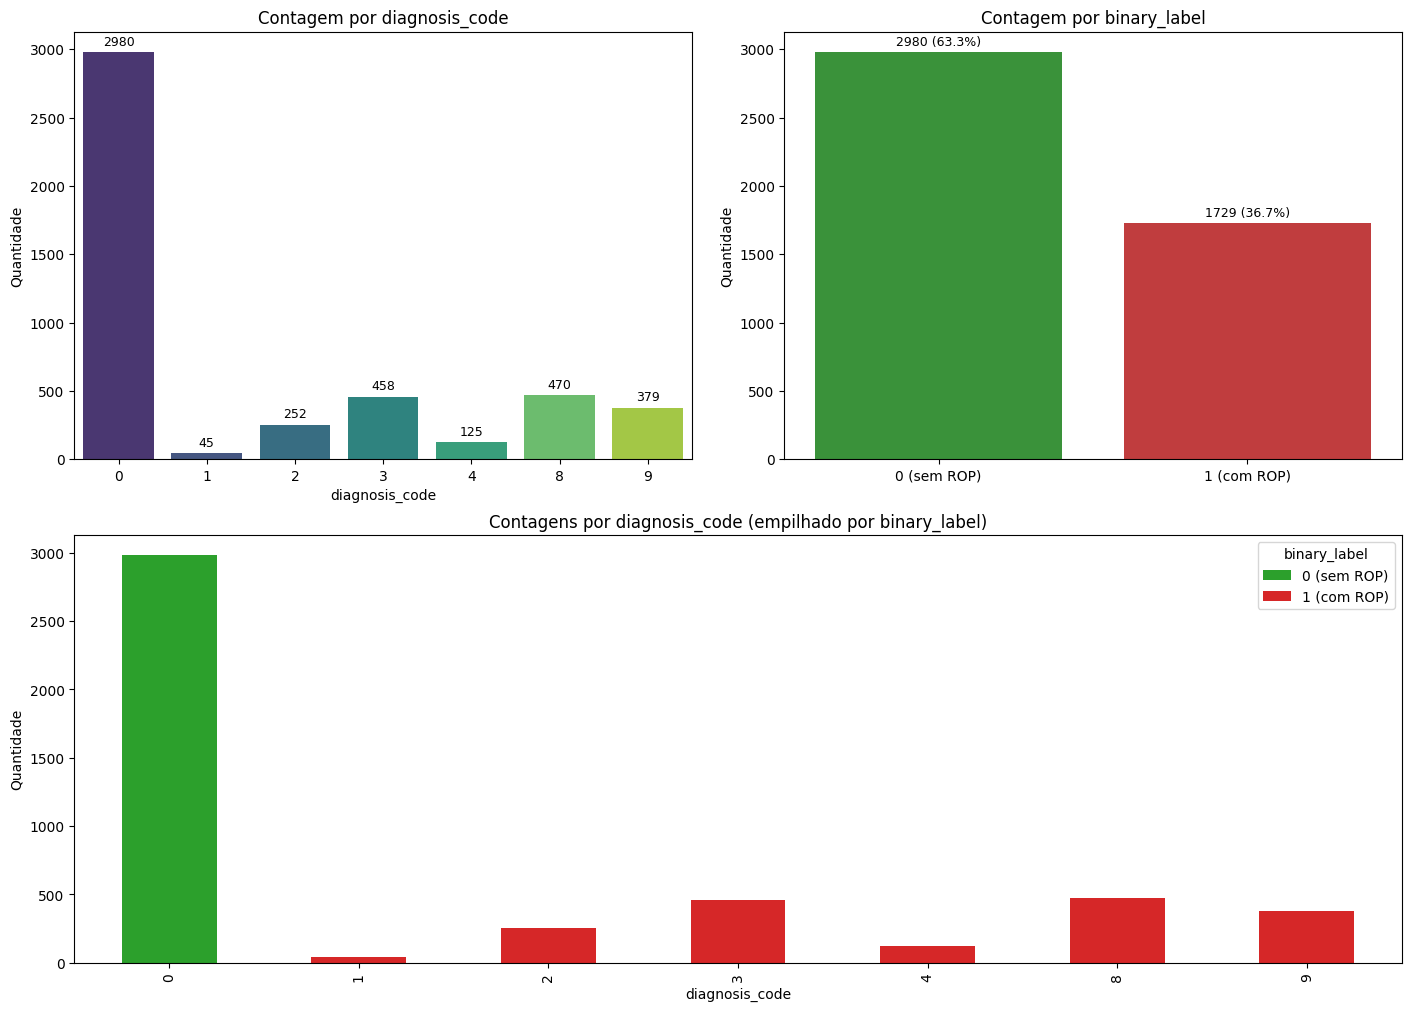

In [10]:
# contagens por código de diagnóstico
diag_counts = df['diagnosis_code'].value_counts().sort_index()

# contagens binárias
binary_counts = df['binary_label'].value_counts().sort_index()

# preparo da figura (dois gráficos na linha de cima + gráfico empilhado em baixo)
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(14,10))
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1,1])

ax0 = fig.add_subplot(gs[0,0])   # diagnóstico por código
ax1 = fig.add_subplot(gs[0,1])   # binário
ax2 = fig.add_subplot(gs[1,:])   # empilhado por código vs binário

# gráfico 1: barras por diagnosis_code
sns.barplot(x=diag_counts.index.astype(str), y=diag_counts.values, palette='viridis', ax=ax0)
ax0.set_title('Contagem por diagnosis_code')
ax0.set_xlabel('diagnosis_code')
ax0.set_ylabel('Quantidade')
for i, v in enumerate(diag_counts.values):
    ax0.text(i, v + max(diag_counts.values)*0.01, str(v), ha='center', va='bottom', fontsize=9)

# gráfico 2: barras para binary_label (mostrando percentual e total)
labels = ['0 (sem ROP)', '1 (com ROP)']
vals = [binary_counts.get(0, 0), binary_counts.get(1, 0)]
sns.barplot(x=labels, y=vals, palette=['#2ca02c','#d62728'], ax=ax1)
ax1.set_title('Contagem por binary_label')
ax1.set_ylabel('Quantidade')
for i, v in enumerate(vals):
    pct = v / sum(vals) * 100 if sum(vals) > 0 else 0
    ax1.text(i, v + max(vals)*0.01, f"{v} ({pct:.1f}%)", ha='center', va='bottom', fontsize=9)

# gráfico 3: empilhado (por diagnosis_code, dividido por binary_label)
grouped = df.groupby(['diagnosis_code', 'binary_label']).size().unstack(fill_value=0).sort_index()
# garante colunas 0 e 1
for c in [0,1]:
    if c not in grouped.columns:
        grouped[c] = 0
grouped = grouped[[0,1]]  # ordem consistente

grouped.plot(kind='bar', stacked=True, ax=ax2, color=['#2ca02c','#d62728'])
ax2.set_title('Contagens por diagnosis_code (empilhado por binary_label)')
ax2.set_xlabel('diagnosis_code')
ax2.set_ylabel('Quantidade')
ax2.legend(['0 (sem ROP)', '1 (com ROP)'], title='binary_label')

plt.show()

In [12]:
rop_dataset = ROPDataset(df, is_train=False, apply_clahe=True)
X_train, y_train, train_indx, patient_ids_train, gkf, test_dataset = data_factory.prepare_data_for_cross_validation(rop_dataset)

print("\n=== Distribuição de classes em cada fold (GroupKFold) ===")
for fold, (train_idx_fold, val_idx_fold) in enumerate(gkf.split(X_train, y_train, groups=patient_ids_train)):
    y_train_fold = np.array(y_train)[train_idx_fold]
    y_val_fold = np.array(y_train)[val_idx_fold]

    train_counts = pd.Series(y_train_fold).value_counts().sort_index()
    val_counts = pd.Series(y_val_fold).value_counts().sort_index()

    train_perc = (train_counts / len(y_train_fold) * 100).round(2)
    val_perc = (val_counts / len(y_val_fold) * 100).round(2)

    print(f"\n*Fold {fold+1}")
    print("Treino:")
    for cls in train_counts.index:
        print(f"  Classe {cls}: {train_counts[cls]} amostras ({train_perc[cls]}%)")
    print("Validação:")
    for cls in val_counts.index:
        print(f"  Classe {cls}: {val_counts[cls]} amostras ({val_perc[cls]}%)")
    print("--------------------------------------------------")


Numero de amostras no conjunto de treino: 3983
Numero de amostras no conjunto de teste: 726

=== Distribuição de classes em cada fold (GroupKFold) ===

*Fold 1
Treino:
  Classe 0: 1925 amostras (60.46%)
  Classe 1: 1259 amostras (39.54%)
Validação:
  Classe 0: 329 amostras (41.18%)
  Classe 1: 470 amostras (58.82%)
--------------------------------------------------

*Fold 2
Treino:
  Classe 0: 1767 amostras (55.5%)
  Classe 1: 1417 amostras (44.5%)
Validação:
  Classe 0: 487 amostras (60.95%)
  Classe 1: 312 amostras (39.05%)
--------------------------------------------------

*Fold 3
Treino:
  Classe 0: 1747 amostras (54.83%)
  Classe 1: 1439 amostras (45.17%)
Validação:
  Classe 0: 507 amostras (63.61%)
  Classe 1: 290 amostras (36.39%)
--------------------------------------------------

*Fold 4
Treino:
  Classe 0: 1767 amostras (55.41%)
  Classe 1: 1422 amostras (44.59%)
Validação:
  Classe 0: 487 amostras (61.34%)
  Classe 1: 307 amostras (38.66%)
----------------------------------

# Checar imagens teste

In [34]:
X_train, y_train, train_indx, patient_ids_train, gkf, test_dataset = data_factory.prepare_data_for_cross_validation(rop_dataset)


Numero de amostras no conjunto de treino: 3983
Numero de amostras no conjunto de teste: 726


In [35]:
test_dataset

## Visualiza imagens

In [8]:
from torch.utils.data import DataLoader
import torch

In [23]:
rop_dataset = ROPDataset(df, is_train=False, apply_clahe=True)

In [17]:
from torchvision import transforms

def custom_collate_fn(batch):
    transform = transforms.ToTensor()
    
    images = []
    labels = []
    
    for item in batch:
        if len(item) == 3:
            image, label, _ = item  # ignora patient_id
            if hasattr(image, 'mode'):  # PIL.Image
                image = transform(image)
            images.append(image)
            labels.append(label)
    
    return torch.stack(images), torch.tensor(labels)


In [30]:
loader = DataLoader(rop_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
images, labels = next(iter(loader))

In [31]:
images[0].shape

torch.Size([3, 224, 224])

In [32]:
images[0].min(), images[0].max(), images[0].mean()

(tensor(0.), tensor(1.), tensor(0.4288))

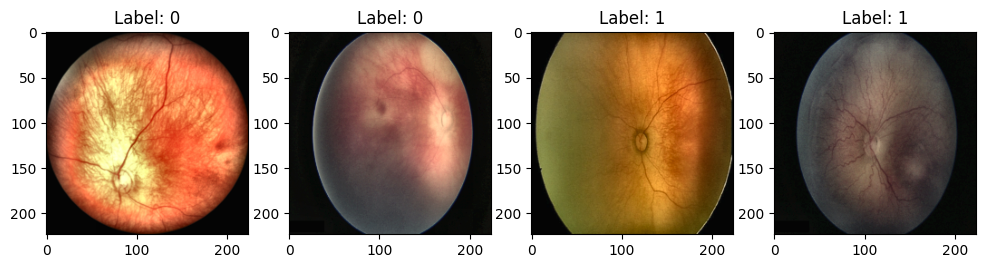

In [33]:
# Mostrar as imagens
plt.figure(figsize=(12, 6))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    img = images[i].permute(1, 2, 0).numpy()  # CxHxW para HxWxC
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('on')
plt.show()